In [44]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Data acquisition
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file using pandas
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Data inspection
print("First 5 rows of the dataset:")
print(df.head())

# Handle missing values
df = df.dropna().reset_index(drop=True)

# Encode target variable
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])  # 'bot' -> 0, 'human' -> 1

# Convert boolean columns
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode categorical features
df['lang_encoded'] = le.fit_transform(df['lang'])

# Feature selection
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'id',
    'profile_background_image_url', 'profile_image_url',
    'screen_name', 'location', 'account_type', 'lang'
])

# TF-IDF Vectorization for 'description' field
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_description_tfidf = tfidf_vectorizer.fit_transform(df['description'])
X_description_tfidf = X_description_tfidf.toarray()  # Now this is a numeric array

# Define numerical features (excluding the 'description' and 'account_type_encoded' columns)
X_numerical = df_model.drop(columns=['account_type_encoded', 'description'], axis=1)

# Combine the TF-IDF vectors (text data) with the numerical features
X_combined = np.hstack((X_numerical.to_numpy(), X_description_tfidf))  # Combine numerical and text features

# Target variable
y = df_model['account_type_encoded']

# Addressing class imbalance in the training data
# Create a DataFrame with the combined features and target
df_combined = pd.DataFrame(X_combined)

# Ensure the target variable is correctly added
df_combined['account_type_encoded'] = y

# Separate majority and minority classes
df_majority = df_combined[df_combined['account_type_encoded'] == 1]  # Human
df_minority = df_combined[df_combined['account_type_encoded'] == 0]  # Bot

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,              # sample with replacement
                                   n_samples=len(df_majority),  # match majority class size
                                   random_state=42)

# Combine majority class with oversampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Separate features and target for balanced dataset
X_balanced = df_balanced.drop('account_type_encoded', axis=1).to_numpy()
y_balanced = df_balanced['account_type_encoded']

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Train-test split with balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

First 5 rows of the dataset:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2016-10-15 21:32:11            False                  False   
1           1  2016-11-09 05:01:30            False                  False   
2           2  2017-06-17 05:34:27            False                  False   
3           3  2016-07-21 13:32:25             True                  False   
4           4  2012-01-15 16:32:35            False                  False   

                                         description  favourites_count  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...                 4   
1  Photographing the American West since 1980. I ...               536   
2  Scruffy looking nerf herder and @twitch broadc...              3307   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...              8433   
4               Loan coach at @mancity & Aspiring DJ                88   

   followers_count  friends_count  geo_enabled           

In [45]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.4)  # Increased dropout
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.4)  # Increased dropout
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x

# Initialize model, loss function, and optimizer
model = FeedForwardNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0015)

# Training loop with early stopping
num_epochs = 50
patience = 5
best_loss = float('inf')
early_stop_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
    
    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred.extend(outputs.squeeze().numpy())

y_pred_binary = (np.array(y_pred) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Epoch 1, Train Loss: 0.4988, Validation Loss: 0.4395
Epoch 2, Train Loss: 0.4533, Validation Loss: 0.4213
Epoch 3, Train Loss: 0.4354, Validation Loss: 0.4105
Epoch 4, Train Loss: 0.4267, Validation Loss: 0.3996
Epoch 5, Train Loss: 0.4202, Validation Loss: 0.3904
Epoch 6, Train Loss: 0.4137, Validation Loss: 0.3885
Epoch 7, Train Loss: 0.4086, Validation Loss: 0.3854
Epoch 8, Train Loss: 0.4029, Validation Loss: 0.3887
Epoch 9, Train Loss: 0.3971, Validation Loss: 0.3786
Epoch 10, Train Loss: 0.3983, Validation Loss: 0.3801
Epoch 11, Train Loss: 0.3899, Validation Loss: 0.3766
Epoch 12, Train Loss: 0.3889, Validation Loss: 0.3722
Epoch 13, Train Loss: 0.3891, Validation Loss: 0.3764
Epoch 14, Train Loss: 0.3823, Validation Loss: 0.3682
Epoch 15, Train Loss: 0.3772, Validation Loss: 0.3660
Epoch 16, Train Loss: 0.3760, Validation Loss: 0.3676
Epoch 17, Train Loss: 0.3744, Validation Loss: 0.3662
Epoch 18, Train Loss: 0.3789, Validation Loss: 0.3681
Epoch 19, Train Loss: 0.3712, Validat

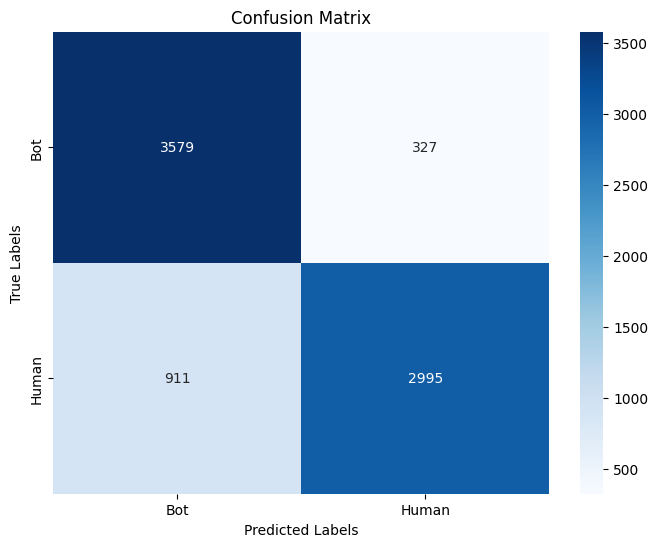

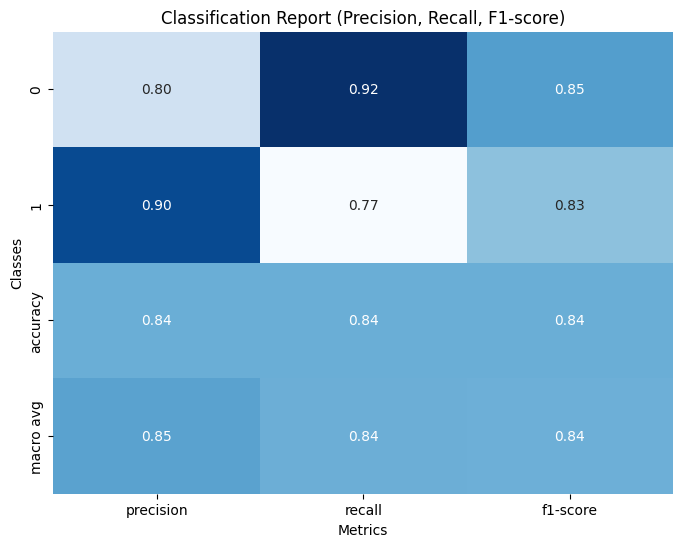

In [47]:
cm = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bot", "Human"], yticklabels=["Bot", "Human"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Convert classification report to a DataFrame for easy plotting
report_df = pd.DataFrame(report).transpose()

# Plot Classification Report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Classification Report (Precision, Recall, F1-score)")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()
